In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/harsh/mynlpenv/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-macos


In [1]:
# Imports
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
data = pd.read_csv('Zomato Dataset.csv')
print(data.head())
print(data.info())
print(data.describe())

         date        open        high         low       close   adj close  \
0  23-07-2021  116.000000  138.899994  115.000000  126.000000  126.000000   
1  26-07-2021  126.349998  143.750000  125.300003  140.649994  140.649994   
2  27-07-2021  141.699997  147.800003  127.750000  132.899994  132.899994   
3  28-07-2021  131.000000  135.000000  123.550003  131.199997  131.199997   
4  29-07-2021  134.949997  144.000000  132.199997  141.550003  141.550003   

      volume  
0  694895290  
1  249723854  
2  240341900  
3  159793731  
4  117973089  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       698 non-null    object 
 1   open       698 non-null    float64
 2   high       698 non-null    float64
 3   low        698 non-null    float64
 4   close      698 non-null    float64
 5   adj close  698 non-null    float64
 6   volume     698 non

Text(0, 0.5, 'Price (USD)')

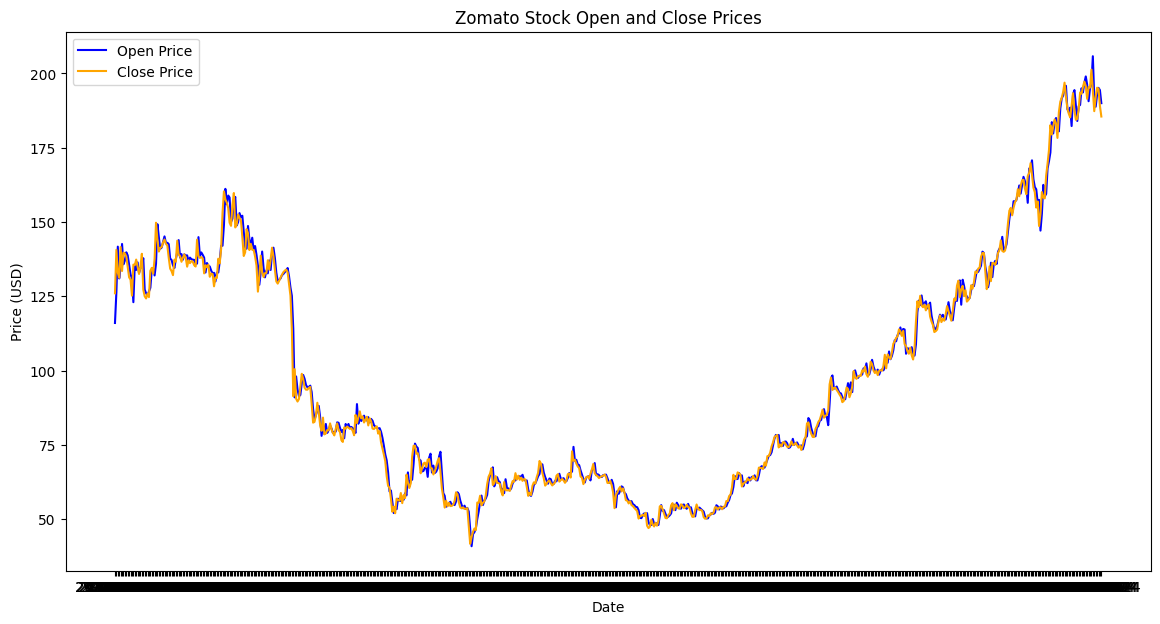

In [4]:
# Initial data visualization 
# Plot 1 : Open and Close prices
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['open'], label='Open Price', color='blue')
plt.plot(data['date'], data['close'], label='Close Price', color='orange')
plt.title('Zomato Stock Open and Close Prices')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Price (USD)')

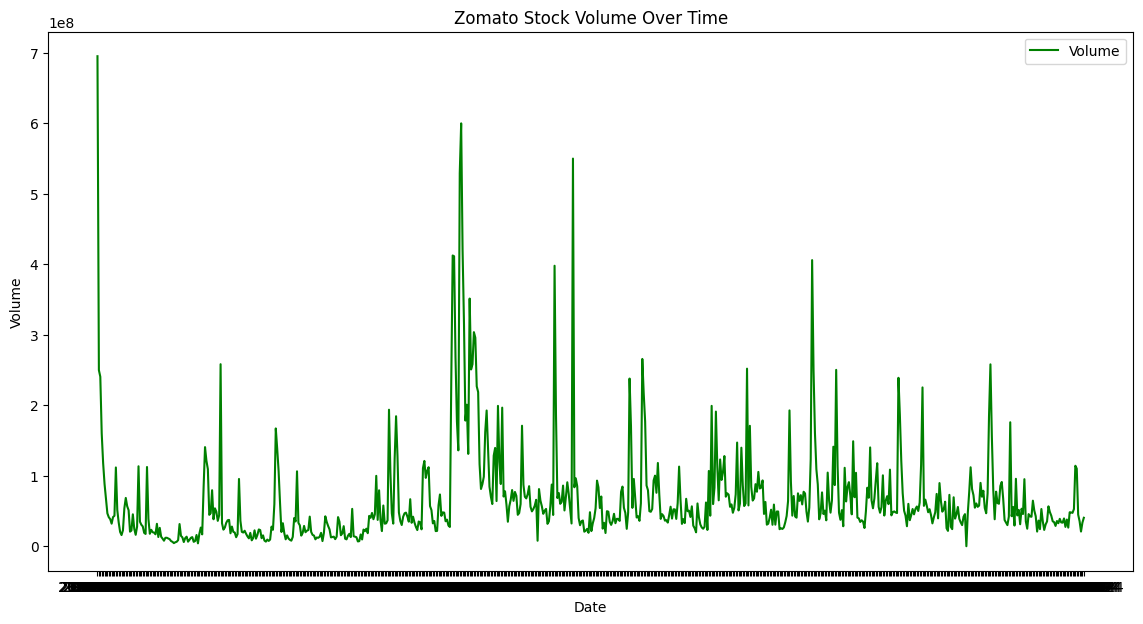

In [5]:
# Plot 2 : Volume over time
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['volume'], label='Volume', color='green')
plt.title('Zomato Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


In [6]:
# Drop unnecessary columns (non-numeric or redundant)
numeric_data = data.select_dtypes(include=["int64", "float64"])

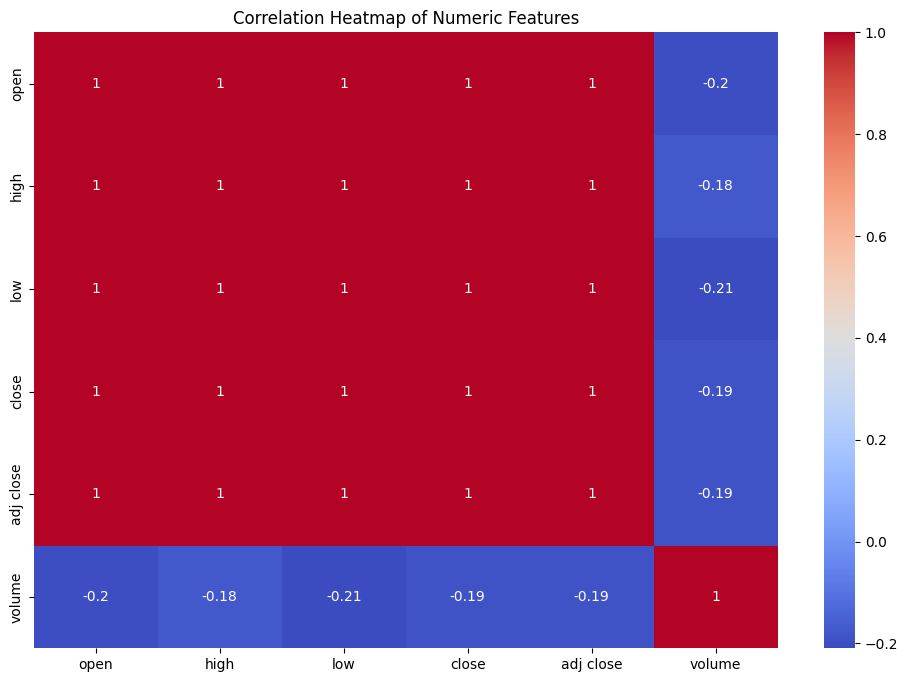

In [7]:
# Check for correlation between numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [8]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

/var/folders/lk/9zql6l_s4fn6rj08c1xp00k00000gn/T/ipykernel_24966/171441334.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'])


In [ ]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) & (data['date'] < datetime(2018,1,1))
]

In [9]:
# Prepare the LSTM Model (Sequential)
dataset = data['close'].values 
train_size = int(np.ceil(len(dataset) * 0.80))

In [10]:
print(dataset.reshape(-1, 1).shape)

(698, 1)


In [11]:
# Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
training_data = scaled_data[:train_size]

In [12]:
X_train, y_train = [], []

# Create a sliding window of 60 days for the stock
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
print(X_train.shape)

(499, 60)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Making it 3D for Tensorflow
print(X_train.shape)

(499, 60, 1)


# Building the Model

In [15]:
model = keras.models.Sequential()

In [16]:
# First layer - learns the patterns from past 60 days of stock prices 
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

2025-06-14 20:08:01.885353: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-14 20:08:01.886362: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-14 20:08:01.886366: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-14 20:08:01.887336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-14 20:08:01.888637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/harsh/mynlpenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

In [17]:
# Second layer - This layer keeps the important features from the first layer
model.add(keras.layers.LSTM(units=64, return_sequences=False))

In [18]:
# Third Layer (Dense Layer) - This layer helps the model adjust and learn complex patterns in the data
model.add(keras.layers.Dense(units=128, activation='relu'))

In [19]:
# Fourth Layer (Dropout Layer) , to prevent overfitting - it prevents the model from being too sensitive to the training data and helps it perform better on new data
model.add(keras.layers.Dropout(0.5))

In [20]:
# Final output layer - This layer predicts the stock prices 
model.add(keras.layers.Dense(units=1)) 

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

# Train the model

In [23]:
training = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30


2025-06-14 20:08:21.706703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.4376 - root_mean_squared_error: 0.5328
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1781 - root_mean_squared_error: 0.2360
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1319 - root_mean_squared_error: 0.1788
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1241 - root_mean_squared_error: 0.1688
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1249 - root_mean_squared_error: 0.1675
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1254 - root_mean_squared_error: 0.1751
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1152 - root_mean_squared_error: 0.1593
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1167 - root_mean_squared_error: 0.1542
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1212 - root_mean_squared_error: 0.1710
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1107 - root_mean_squared_error: 0.1585
Epoch 11/3

In [24]:
# Prep test data
test_data = scaled_data[train_size - 60:]
X_test, y_test = [], dataset[train_size:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
# Make predictions 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


/var/folders/lk/9zql6l_s4fn6rj08c1xp00k00000gn/T/ipykernel_24966/2879287841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


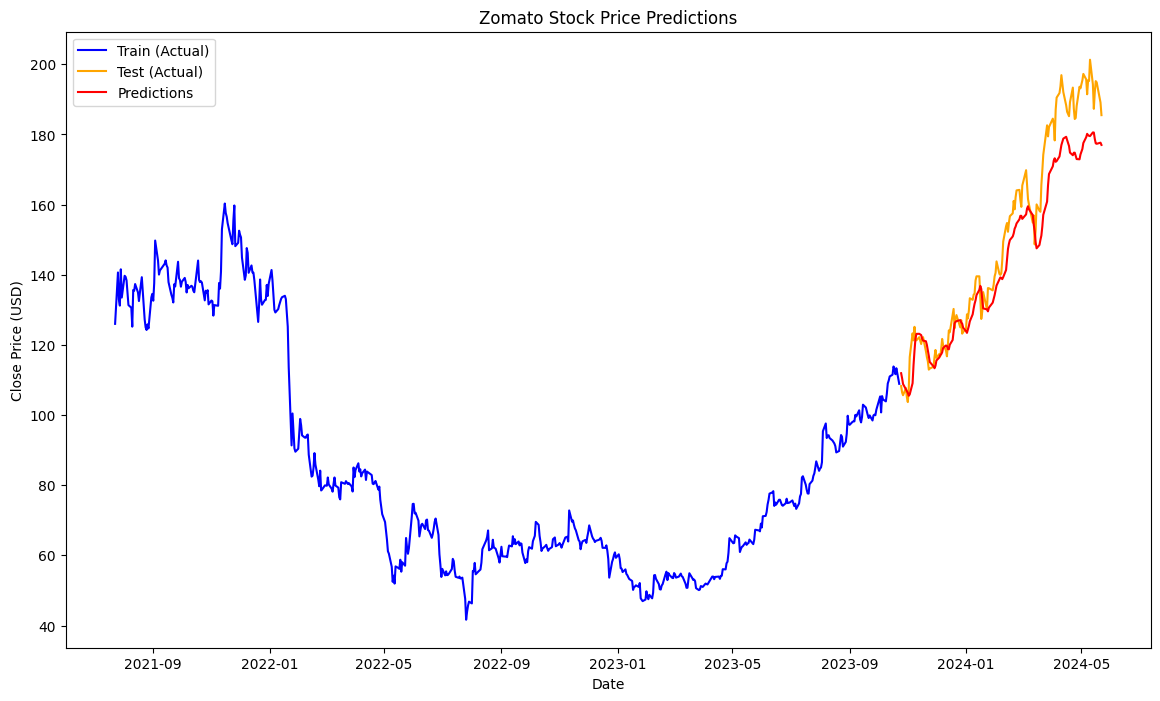

In [26]:
# Plotting data
train = data[:train_size]
test = data[train_size:]
test['Predictions'] = predictions
plt.figure(figsize=(14, 8))
plt.plot(train['date'], train['close'], label='Train (Actual)', color='blue')
plt.plot(test['date'], test['close'], label='Test (Actual)', color='orange')
plt.plot(test['date'], test['Predictions'], label='Predictions', color='red')
plt.title('Zomato Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()